In [1]:
import pandas as pd
import numpy as np
import spacy
import warnings
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.metrics import jaccard_score,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)

In [2]:
df = pd.read_csv('Datasets/stackoverflow.csv')
df.drop('Unnamed: 0',1,inplace = True)
df.head()

,Text,Tags
0,aspnet site maps has anyone got experience cre...,"['sql', 'asp.net']"
1,adding scripting functionality to net applicat...,"['c#', '.net']"
2,should i use nested classes in this case i am ...,['c++']
3,homegrown consumption of web services i have b...,['.net']
4,automatically update version number i would li...,['c#']


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48976 entries, 0 to 48975
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    48976 non-null  object
 1   Tags    48976 non-null  object
dtypes: object(2)
memory usage: 765.4+ KB


In [4]:
tags = {}
for i in df['Tags']:
    for j in ast.literal_eval(i):
        if j in tags:
            tags[j] += 1
        else:
            tags[j] = 1
tags

{'sql': 1389,
 'asp.net': 1302,
 'c#': 6907,
 '.net': 2705,
 'c++': 4369,
 'html': 2129,
 'c': 1845,
 'php': 3024,
 'mysql': 1286,
 'ruby': 1249,
 'java': 6862,
 'javascript': 5560,
 'css': 1980,
 'objective-c': 1768,
 'python': 4442,
 'ruby-on-rails': 1524,
 'jquery': 2770,
 'android': 5052,
 'iphone': 1781,
 'ios': 2685}

In [5]:
# Sorting tags
tags = {k: v for k, v in sorted(tags.items(), key = lambda item: item[1], reverse=True)}

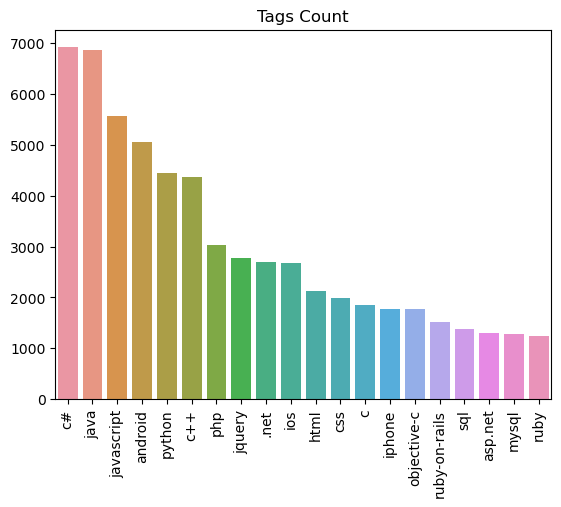

In [6]:
# Visualizing the count of each tag
plt.title("Tags Count")
sns.barplot(list(tags.keys()) , list(tags.values()))
plt.xticks(rotation = 90)
plt.show()

In [7]:
# Preprocessing the Tag column to convert the datatype from string to list
df['Tags'] = df['Tags'].apply(lambda x : ast.literal_eval(x))

# Model Building

In [8]:
# Vectorizing our Text data using TFidf Text Vectorizer
tfidf = TfidfVectorizer(stop_words='english',ngram_range=(1,3),max_features = 1000)
X = tfidf.fit_transform(df['Text'])
y = df['Tags']

In [9]:
X

<48976x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1239765 stored elements in Compressed Sparse Row format>

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=101)

In [11]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((34283, 1000), (14693, 1000), (34283,), (14693,))

In [12]:
# Using MultiLabelBinarizer to encode each tag

multilabel = MultiLabelBinarizer()
y_train = multilabel.fit_transform(y_train)
y_test = multilabel.transform(y_test)

pd.DataFrame(y_train,columns = multilabel.classes_)

,.net,android,asp.net,c,c#,c++,css,html,ios,iphone,java,javascript,jquery,mysql,objective-c,php,python,ruby,ruby-on-rails,sql
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34278,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34279,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
34280,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
34281,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Logistic Regression

In [13]:
lr = LogisticRegression(solver='lbfgs',n_jobs=-1)
clf_lr = OneVsRestClassifier(lr)
clf_lr.fit(X_train,y_train)

y_pred_lr = clf_lr.predict(X_test)

# jaccard_score returns an array of different scores  
np.mean(jaccard_score(y_test,y_pred_lr,average='samples'))

0.4853070623199256

# Linear SVC

In [14]:
svm = LinearSVC(C = 1.5, penalty='l1', dual = False)
clf_svm = OneVsRestClassifier(svm)
clf_svm.fit(X_train, y_train)

y_pred_svm = clf_svm.predict(X_test)

np.mean(jaccard_score(y_test,y_pred_svm,average='samples'))

0.5335670046961137

# RandomForestClassifier

In [15]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1))
clf_rf.fit(X_train, y_train)

y_pred_rf = clf_rf.predict(X_test)

np.mean(jaccard_score(y_test,y_pred_rf,average='samples'))

0.5002597608838676

# Testing our model

In [24]:
x = ['I have good coding knowledge of sql but now i feel more proficient in python']
xt = tfidf.transform(x)
multilabel.inverse_transform(clf_svm.predict(xt))

[('python', 'sql')]